In [ ]:
! pip install numpyro corner healpy einops reproject

In [ ]:
# run only if LaTeX is needed
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r'/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/')
%cd /content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks


In [37]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import logging
logging.getLogger().setLevel(logging.ERROR)

import jax
import numpyro.handlers as handlers
from numpyro.infer import Trace_ELBO

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('matplotlibrc')

In [17]:
from models.poissonian_cart import GCEPyModel

In [42]:
output_dir = '../outputs/posteriors/compare_gcepy'

## 1. fit
### 1.1 single energy

In [58]:
ebinmodel = GCEPyModel(dif_names=['7p'], gce_names=['dm', 'c19'], normalize_gce=True, include_nuclear_bulges=False)
run_name = '7p_dmc19_nuts'
os.makedirs(f'{output_dir}/{run_name}', exist_ok=True)

In [59]:
key = jax.random.PRNGKey(4242)

for ie in range(14):
    print(ie, ':')
    key, subkey = jax.random.split(key)
    svi_results = ebinmodel.fit_SVI(
        rng_key=subkey,
        guide='iaf', num_flows=5, hidden_dims=[128, 128],
        n_steps=20000, lr=3e-5, num_particles=64,
        ebin=ie, error_mode='none',
    )
    key, subkey = jax.random.split(key)
    mcmc = ebinmodel.run_nuts(
        num_samples=20000, rng_key=subkey, use_neutra=True,
        ebin=ie, error_mode='none'
    )
    samples = ebinmodel.expand_samples(mcmc.get_samples())
    # samples = ebinmodel.get_svi_samples(num_samples=50000, expand_samples=True)
    pickle.dump(samples, open(f'{output_dir}/{run_name}/ie{ie}_samples.p', 'wb'))
    # pickle.dump((svi_results, None), open(f'{output_dir}/{run_name}/ie{ie}_fitinfo.p', 'wb'))

0 :


sample: 100%|██████████| 20500/20500 [03:50<00:00, 89.11it/s]


1 :


sample: 100%|██████████| 20500/20500 [03:50<00:00, 89.12it/s]


2 :


sample: 100%|██████████| 20500/20500 [03:52<00:00, 88.07it/s]


3 :


sample: 100%|██████████| 20500/20500 [03:52<00:00, 88.22it/s]


4 :


sample: 100%|██████████| 20500/20500 [03:52<00:00, 88.22it/s]


5 :


sample: 100%|██████████| 20500/20500 [03:50<00:00, 88.78it/s]


6 :


sample: 100%|██████████| 20500/20500 [03:57<00:00, 86.50it/s]


7 :


sample: 100%|██████████| 20500/20500 [03:57<00:00, 86.49it/s]


8 :


sample: 100%|██████████| 20500/20500 [03:56<00:00, 86.61it/s]


9 :


sample: 100%|██████████| 20500/20500 [03:55<00:00, 87.04it/s]


10 :


sample: 100%|██████████| 20500/20500 [03:50<00:00, 88.88it/s]


11 :


sample: 100%|██████████| 20500/20500 [03:55<00:00, 86.97it/s]


12 :


sample: 100%|██████████| 20500/20500 [03:58<00:00, 86.12it/s]


13 :


sample: 100%|██████████| 20500/20500 [03:58<00:00, 85.95it/s]


### 1.2 single energy multiple runs (ELBO only)
1000 particle ELBO estimate is good enough (smaller than inter-run variations).

In [ ]:
ebinmodel = GCEPyModel(dif_names=['8t'], gce_names=['c19'], include_nuclear_bulges=True)
run_name = '8t_c19_n'

n_ebin = 14
n_run = 5
elbo_arr = np.zeros((n_ebin, n_run))
key = jax.random.PRNGKey(42424242)

for ie in range(n_ebin):
    print(ie, ':')
    for i_run in range(n_run):
        key, subkey = jax.random.split(key)
        svi_results = ebinmodel.fit_SVI(
            rng_key=subkey,
            guide='iaf', num_flows=5, hidden_dims=[128, 128],
            n_steps=20000, lr=3e-5, num_particles=64,
            ebin=ie, error_mode='none',
        )
        trace_elbo = Trace_ELBO(num_particles=1000)
        key, subkey = jax.random.split(key)
        elbo_loss = trace_elbo.loss(
            subkey,
            svi_results.params, ebinmodel.model, ebinmodel.guide,
            ebin=ie, error_mode='none',
        )
        elbo_arr[ie, i_run] = elbo_loss
np.save(f"{output_dir}/{run_name}_elbo_arr.npy", elbo_arr)

In [ ]:
plt.plot(svi_results.losses)
plt.loglog()

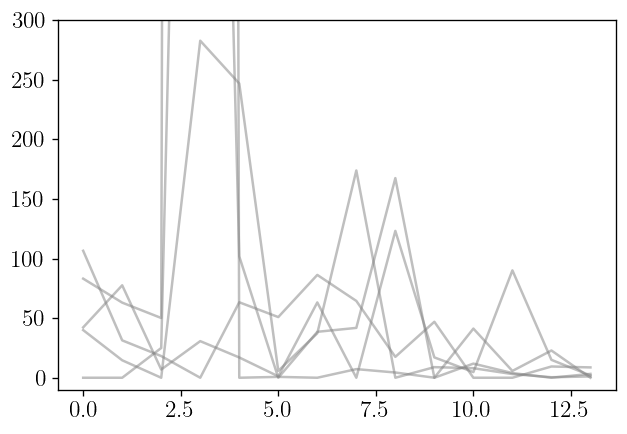

In [ ]:
fig, ax = plt.subplots()

base = np.min(elbo_arr, axis=1)

for i_run in range(n_run):
    ax.plot(elbo_arr[:, i_run]-base, color='gray', alpha=0.5)
    ax.set(ylim=(-10, 300))

[]

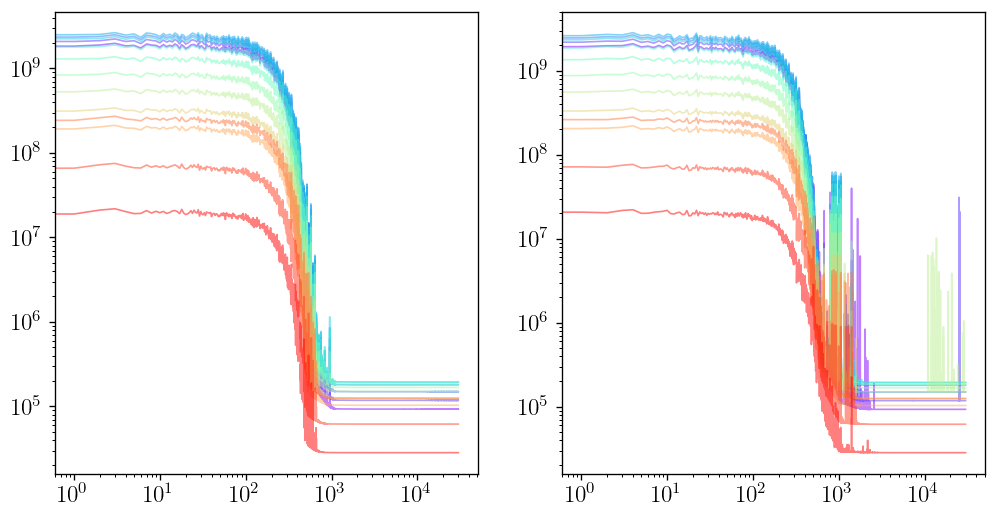

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ie in range(14):
    svi_results, _ = pickle.load(open(f'{output_dir}/8t_c19_n/ie{ie}_fitinfo.p', 'rb'))
    axs[0].plot(svi_results.losses, alpha=0.5, color=cms['rainbow'](ie/13), lw=1)
    svi_results, _ = pickle.load(open(f'{output_dir}/8t_dm_n/ie{ie}_fitinfo.p', 'rb'))
    axs[1].plot(svi_results.losses, alpha=0.5, color=cms['rainbow'](ie/13), lw=1)
axs[0].loglog()
axs[1].loglog()

### 1.2 full

In [ ]:
svi_results = ebinmodel.fit_SVI(
    rng_key=jax.random.PRNGKey(434534),
    num_flows=5, hidden_dims=[128, 128],
    n_steps=20000, lr=5e-5, num_particles=64,
    ebin='all',
    error_mode='none',
)

In [ ]:
svi_results.losses[-1]

In [ ]:
samples = ebinmodel.get_svi_samples(num_samples=50000, expand_samples=True)
pickle.dump((samples, svi_results), open(f'{output_dir}/gcepy_svi_full_errll_par16_3.p', 'wb'))

## 2. Plotting

In [24]:
from utils.plotting import multi_corner

In [12]:
ebin_edges = np.array([0.275, 0.357, 0.464, 0.603, 0.784, 1.02, 1.32, 1.72,
                       2.24, 2.91, 3.78, 4.91, 10.8, 23.7, 51.9])
ebin_centers = (ebin_edges[1:] + ebin_edges[:-1]) / 2

### 2.1 corner

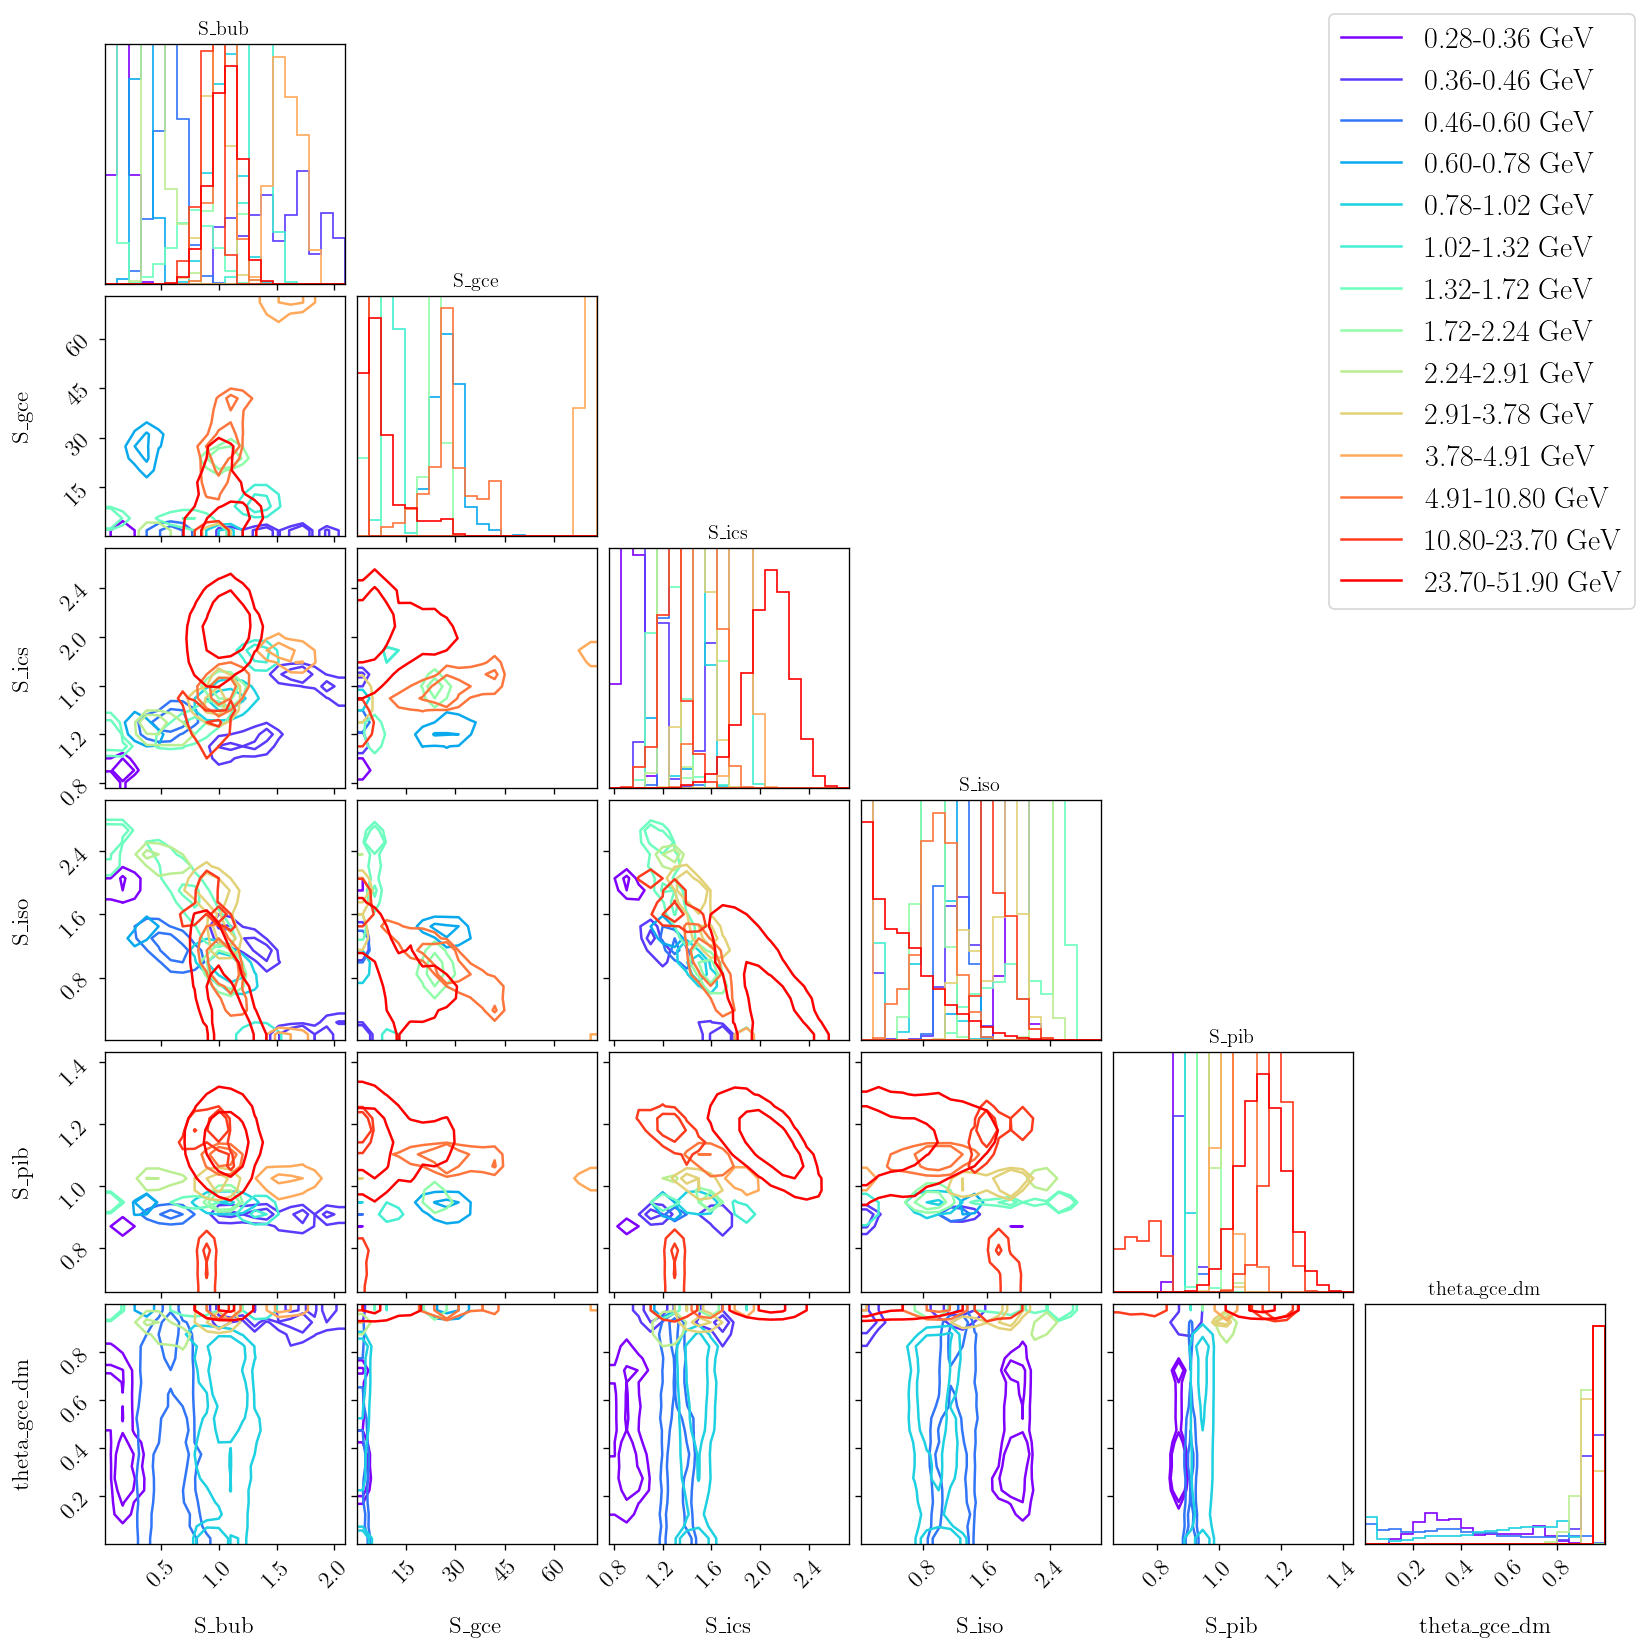

In [61]:
ie_tot = 14
samples_dict = {
    str(ie) : pickle.load(open(f'{output_dir}/7p_dmc19_nuts/ie{ie}_samples.p', 'rb'))
    for ie in range(ie_tot)
}
colors_dict = {
    str(ie) : cms['rainbow'](ie/(ie_tot-1))
    for ie in range(ie_tot)
}
labels_dict = {
    str(ie) : f'{ebin_edges[ie]:.2f}-{ebin_edges[ie+1]:.2f} GeV'
    for ie in range(ie_tot)
}
plot_var_names = [
    'S_bub', 'S_gce', 'S_ics', 'S_iso', 'S_pib', 'theta_gce_dm'
]

logging.getLogger().setLevel(logging.ERROR)
multi_corner(
    samples_dict, plot_var_names,
    colors_dict=colors_dict, labels_dict=labels_dict,
    hist_bin_factor=1, save_fn='../outputs/posteriors/plots/gcepy_dmc19_nuts_7p.pdf'
)

### 2.2 evidence

In [ ]:
#run_names = ['7p_dm', '7p_c19', '8t_dm', '8t_c19', '7p_c19nopsf', '8t_c19nopsf']
run_names = ['7p_dm_n', '7p_c19_n', '8t_dm_n', '8t_c19_n',]
recalculate_elbo = False

elbo_dict = {}
for run_name in run_names:
    neg_elbo_list = []
    for ie in tqdm(range(14)):

        if recalculate_elbo:
            svi_result = pickle.load(open(f'{output_dir}/{run_name}/ie{ie}_fitinfo.p', 'rb'))[0]
            trace_elbo = Trace_ELBO(num_particles=5000)
            elbo_loss = trace_elbo.loss(
                jax.random.PRNGKey(4242),
                svi_results.params,
                ebinmodel.model,
                ebinmodel.guide,
                ebin=ie,
                error_mode='none',
            )
        else:
            elbo_loss = pickle.load(open(f'{output_dir}/{run_name}/ie{ie}_fitinfo.p', 'rb'))[1]

        neg_elbo_list.append(elbo_loss)

    elbo_dict[run_name] = - np.array(neg_elbo_list)

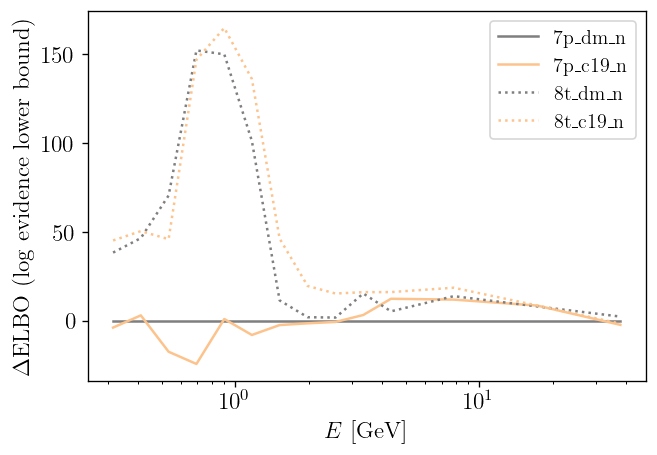

In [ ]:
color_dict = {
    'dm' : mpl.colormaps['binary'](0.5),
    'c19' : mpl.colormaps['Oranges'](0.3),
    'c19nopsf' : mpl.colormaps['Oranges'](0.7),
}
linestyle_dict = {
    '7p' : '-',
    '8t' : ':',
}
base = elbo_dict['7p_dm_n']

fig, ax = plt.subplots()

for i, run_name in enumerate(run_names):
    color = color_dict[run_name.split('_')[1]]
    linestyle = linestyle_dict[run_name.split('_')[0]]
    ax.plot(ebin_centers, elbo_dict[run_name]-base, color=color, label=run_name, linestyle=linestyle)
ax.set(xscale='log')
ax.set(xlabel='$E$ [GeV]', ylabel='$\Delta$ELBO (log evidence lower bound)')
ax.legend(fontsize=12)
plt.savefig("../output/gcepy_elbos_n.pdf")

In [ ]:
samples_dict = {
    'noerr' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full.p', 'rb'))[0],
    #'errll' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll.p', 'rb'))[0],
    'errll_1' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_1.p', 'rb'))[0],
    'errll_2' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_2.p', 'rb'))[0],
    'errll_3' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_3.p', 'rb'))[0],
}
colors_dict = {
    'noerr' : mpl.colormaps['binary'](0.5),
    'errll' : mpl.colormaps['binary'](0.9),
    'errll_1' : mpl.colormaps['viridis'](0.7),
    'errll_2' : mpl.colormaps['viridis'](0.8),
    'errll_3' : mpl.colormaps['viridis'](0.9),
}
labels_dict = {
    'noerr' : 'No errors',
    'errll' : 'Errors in log likelihood',
    'errll_1' : 'Errors in log likelihood run 1 (num_particle=16)',
    'errll_2' : 'Errors in log likelihood run 2 (num_particle=16)',
    'errll_3' : 'Errors in log likelihood run 3 (num_particle=16)',
}
plot_var_names = [
    'theta_gce_bb', 'theta_gce_dm',
    'S_bub', 'S_gce', 'S_ics', 'S_iso', 'S_pib',
]
multi_corner(
    samples_dict, plot_var_names,
    colors_dict=colors_dict, labels_dict=labels_dict,
    save_fn=f"{output_dir}/plots/gcepy_full.pdf",
)

## Debug

In [ ]:
with handlers.seed(rng_seed=42):
    ll = ebinmodel.model()

In [ ]:
m = GCEPyModel()